In [171]:
# GOES on AWS python utility: https://github.com/palexandremello/goes-py
!pip install goespy

# GOES on AWS: https://docs.opendata.aws/noaa-goes16/cics-readme.html ; https://registry.opendata.aws/noaa-goes/
# https://nbviewer.jupyter.org/github/blaylockbk/pyBKB_v3/blob/master/BB_GOES/mapping_GOES16_TrueColor.ipynb

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [69]:
# Install from conda-force these basemap packages to work with rasters at different resolutions
!conda install --yes -c conda-forge basemap-data-hires

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda:

The following NEW packages will be INSTALLED:

    basemap-data-hires: 1.2.0-0 conda-forge

basemap-data-h 100% |################################| Time: 0:00:04  26.13 MB/s


In [ ]:
!pip install satpy

In [70]:
%matplotlib inline

import rasterio as rio
import rasterio.plot
from pyproj import Proj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
from goespy.Downloader import ABI_Downloader # https://github.com/palexandremello/goes-py

In [9]:
bucket = 'noaa-goes16'
year='2019'
month='03'
day='01'
hour='12'
product='ABI-L1b-RadC'
channel='C14'

In [10]:
goes16_path = '/home/jovyan/goes16' # or if at home 'C:/Users/steve/goes16'
filepath = '{}/{}/{}/{}/{}/{}/{}/'.format(goes16_path,year,month,day,product,hour,channel)
if not os.path.exists(filepath):
    ABI = ABI_Downloader(bucket,year,month,day,hour,product,channel)

In [11]:
file_list = os.listdir(filepath)
file_list

['OR_ABI-L1b-RadC-M3C14_G16_s20190601222133_e20190601224506_c20190601224555.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601227133_e20190601229506_c20190601229552.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601237133_e20190601239506_c20190601239554.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601217133_e20190601219506_c20190601219555.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601222133_e20190601224506_c20190601224555.tif',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601212133_e20190601214506_c20190601214553.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601202133_e20190601204506_c20190601204556.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601247133_e20190601249506_c20190601249556.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601252133_e20190601254506_c20190601254554.nc',
 '.ipynb_checkpoints',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601207133_e20190601209506_c20190601209555.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601232133_e20190601234506_c20190601234555.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601222133_e20190601224506_c20190601224555.png.aux.x

In [12]:
# pick a file from this list
file = filepath + file_list[0]

In [15]:
# open dataset using xarray
C = xr.open_dataset(filepath + file_list[0])

In [16]:
# Scan's start time, converted to datetime object
scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Scan's end time, converted to datetime object
scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
# I'm not a fan of numpy datetime, so I convert it to a regular datetime object
midpoint = str(C['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : %s' % scan_start)
print('Scan midpoint : %s' % scan_mid)
print('Scan End      : %s' % scan_end)
print('File Created  : %s' % file_created)
print('Scan Duration : %.2f minutes' % ((scan_end-scan_start).seconds/60))

Scan Start    : 2019-03-01 12:22:13.300000
Scan midpoint : 2019-03-01 12:23:31.900000
Scan End      : 2019-03-01 12:24:50.600000
File Created  : 2019-03-01 12:24:55.500000
Scan Duration : 2.62 minutes


In [18]:
C['goes_imager_projection']

<xarray.DataArray 'goes_imager_projection' ()>
array(-2147483647, dtype=int32)
Coordinates:
    t        datetime64[ns] 2019-03-01T12:23:31.980631936
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:                       GOES-R ABI fixed grid projection
    grid_mapping_name:               geostationary
    perspective_point_height:        35786023.0
    semi_major_axis:                 6378137.0
    semi_minor_axis:                 6356752.31414
    inverse_flattening:              298.2572221
    latitude_of_projection_origin:   0.0
    longitude_of_projection_origin:  -75.0
    sweep_angle_axis:                x

In [57]:
def getProj4string(goes_imager_projection):
    '''make a proj4 string  and a pyproj geostationary map object from goes imager projection information'''
    h=goes_imager_projection.perspective_point_height
    a=goes_imager_projection.semi_major_axis
    rf=goes_imager_projection.inverse_flattening
    lon0=goes_imager_projection.longitude_of_projection_origin
    lat0=goes_imager_projection.latitude_of_projection_origin
    sweep=goes_imager_projection.sweep_angle_axis
    proj_string = '"+proj=geos +ellps=GRS80 +h={h} +a={a} +rf={rf} +lon_0={lon0} +lat_0={lat0} +sweep={sweep}"'.format(
        h=h,a=a,rf=rf,lon0=lon0,lat0=lat0,sweep=sweep)
    p = Proj(proj='geos', h=h, lon_0=lon0, sweep=sweep)
    return proj_string, p

In [61]:
# make a proj4 string  and a pyproj geostationary map object from this file's projection information
proj_string, p = getProj4string(C.goes_imager_projection)

In [62]:
# Perform cartographic transformation. That is, convert image projection coordinates (x and y)
# to latitude and longitude values.
XX, YY = np.meshgrid(x, y)
lons, lats = p(XX, YY, inverse=True)

In [64]:
# Get the radiance values
R = C['Rad'].data

In [65]:
# Assign the pixels showing space as a single point in the Gulf of Alaska
lats[np.isnan(R)] = 57
lons[np.isnan(R)] = -152

In [ ]:
# Replace nans
lats[np.isnan(lats)]=-9999.0
lons[np.isnan(lons)]=-9999.0
R[np.isnan(R)]=-9999.0

In [210]:
# Make a new map object Lambert Conformal projection
mL = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
             width=3000*3000, height=2500*3000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)

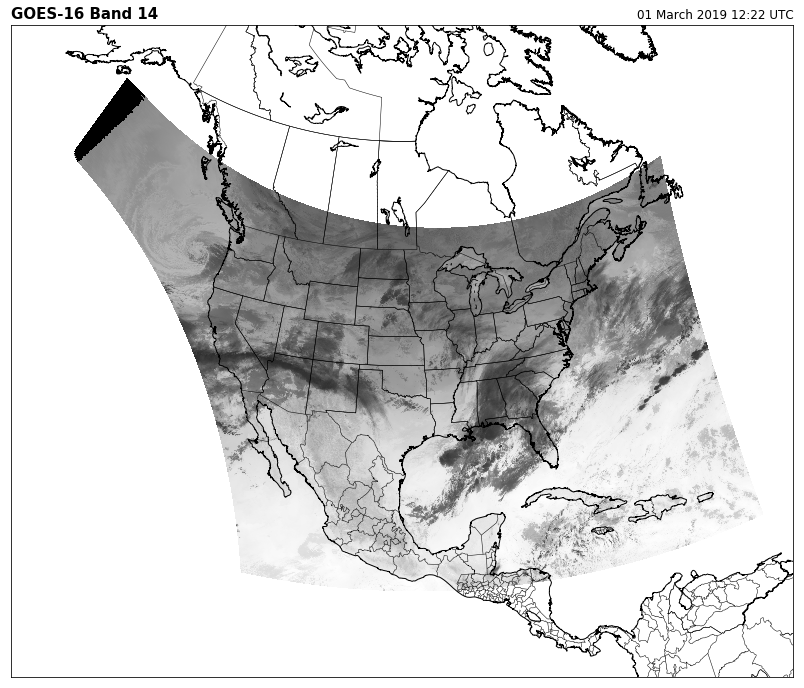

In [209]:
plt.figure(figsize=[15, 12])

# Plotting radiances on our map
newmap = mL.pcolormesh(lons, lats, R, cmap='gray',vmin=0, linewidth=0, latlon=True)

mL.drawcoastlines()
mL.drawcountries()
mL.drawstates()

plt.title('GOES-16 Band 14', loc='left', fontweight='semibold', fontsize=15)
plt.title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC'), loc='right');
#plt.savefig('GOES-16_b14.png')

In [212]:
# Repeat the same for GOES-17

In [213]:
bucket = 'noaa-goes17'
year='2019'
month='03'
day='01'
hour='12'
product='ABI-L1b-RadC'
channel='C14'

goes17_path = '/home/jovyan/goes17' # or if at home 'C:/Users/steve/goes17'
filepath = '{}/{}/{}/{}/{}/{}/{}/'.format(goes17_path,year,month,day,product,hour,channel)
if not os.path.exists(filepath):
    ABI = ABI_Downloader(bucket,year,month,day,hour,product,channel)
    
file_list = os.listdir(filepath)
file_list

Downloading... the product ABI-L1b-RadC 
OR_ABI-L1b-RadC-M3C14_G17_s20190601257189_e20190601259502_c20190601259544.nc: [##########] 100%  5.165361 MB/5.165361 MB

['OR_ABI-L1b-RadC-M3C14_G17_s20190601222189_e20190601224562_c20190601225007.nc',
 'OR_ABI-L1b-RadC-M3C14_G17_s20190601202189_e20190601204562_c20190601205007.nc',
 'OR_ABI-L1b-RadC-M3C14_G17_s20190601242189_e20190601244502_c20190601244544.nc',
 'OR_ABI-L1b-RadC-M3C14_G17_s20190601232189_e20190601234562_c20190601235005.nc',
 'OR_ABI-L1b-RadC-M3C14_G17_s20190601247189_e20190601249562_c20190601250007.nc',
 'OR_ABI-L1b-RadC-M3C14_G17_s20190601227189_e20190601229502_c20190601229546.nc',
 'OR_ABI-L1b-RadC-M3C14_G17_s20190601212189_e20190601214502_c20190601214546.nc',
 'OR_ABI-L1b-RadC-M3C14_G17_s20190601217189_e20190601219562_c20190601220006.nc',
 'OR_ABI-L1b-RadC-M3C14_G17_s20190601237189_e20190601239562_c20190601240006.nc',
 'OR_ABI-L1b-RadC-M3C14_G17_s20190601252189_e20190601254562_c20190601255007.nc',
 'OR_ABI-L1b-RadC-M3C14_G17_s20190601207189_e20190601209562_c20190601210007.nc',
 'OR_ABI-L1b-RadC-M3C14_G17_s20190601257189_e20190601259502_c20190601259544.nc']

In [214]:
# pick a file from this list
file = filepath + file_list[0]

# open dataset using xarray
C_17 = xr.open_dataset(filepath + file_list[0])

In [215]:
# Scan's start time, converted to datetime object
scan_start = datetime.strptime(C_17.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Scan's end time, converted to datetime object
scan_end = datetime.strptime(C_17.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(C_17.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
# I'm not a fan of numpy datetime, so I convert it to a regular datetime object
midpoint = str(C_17['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : %s' % scan_start)
print('Scan midpoint : %s' % scan_mid)
print('Scan End      : %s' % scan_end)
print('File Created  : %s' % file_created)
print('Scan Duration : %.2f minutes' % ((scan_end-scan_start).seconds/60))

Scan Start    : 2019-03-01 12:22:18.900000
Scan midpoint : 2019-03-01 12:23:37.600000
Scan End      : 2019-03-01 12:24:56.200000
File Created  : 2019-03-01 12:25:00.700000
Scan Duration : 2.62 minutes


In [216]:
# make a proj4 string  and a pyproj geostationary map object from this file's projection information
proj_string, p = getProj4string(C_17.goes_imager_projection)

# Perform cartographic transformation. That is, convert image projection coordinates (x and y)
# to latitude and longitude values.
XX, YY = np.meshgrid(x, y)
lons, lats = p(XX, YY, inverse=True)

# Get the radiance values
R = C['Rad'].data

# Assign the pixels showing space as a single point in the Gulf of Alaska
lats[np.isnan(R)] = 57
lons[np.isnan(R)] = -152

# Replace nans
lats[np.isnan(lats)]=-9999.0
lons[np.isnan(lons)]=-9999.0
R[np.isnan(R)]=-9999.0

In [217]:
# Make a new map object Lambert Conformal projection
mL = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
             width=3000*3000, height=2500*3000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)

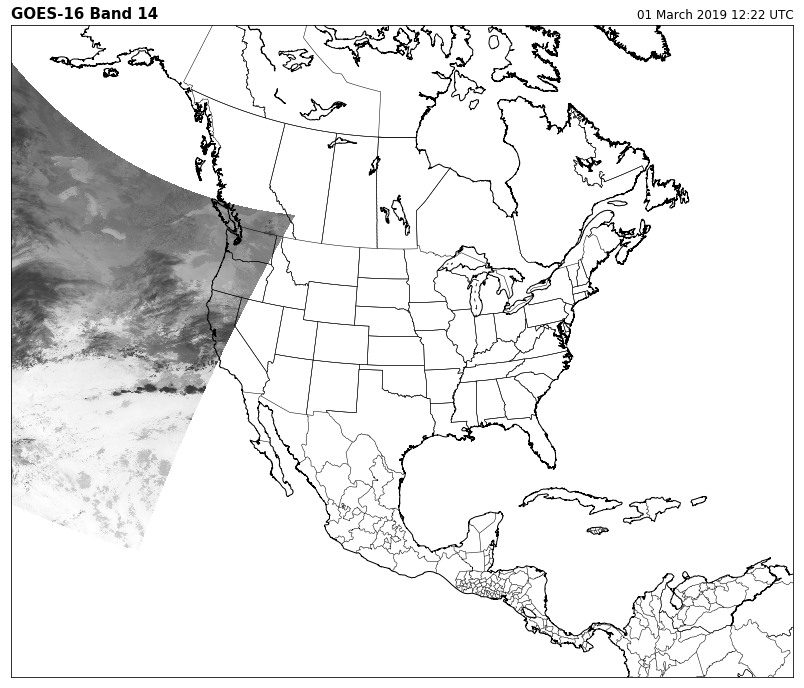

In [218]:
plt.figure(figsize=[15, 12])

# Plotting radiances on our map
newmap = mL.pcolormesh(lons, lats, R, cmap='gray',vmin=0, linewidth=0, latlon=True)

mL.drawcoastlines()
mL.drawcountries()
mL.drawstates()

plt.title('GOES-16 Band 14', loc='left', fontweight='semibold', fontsize=15)
plt.title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC'), loc='right');
#plt.savefig('GOES-16_b14.png')